<div style="color:#336600; font-weight: bold;font-size:28px;line-height:1.2">ECE520 Project1: Exploring Quantum Approximate Optimization Algorithm</div>

<div style="background-color:#e6b800;font-weight: bold;font-size: 20px;line-height:2">Some code is based on the tutorial of qiskit 2021 summer school</div>

In [6]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import copy

from matplotlib import pyplot as plt
from qiskit.circuit import Parameter, ParameterVector
from typing import List
from qiskit import QuantumCircuit,Aer
from qiskit.algorithms.optimizers import ADAM,COBYLA,SLSQP
from time import time

graphsets={}

Define MaxCut Problem: Partial-connected Weighted MaxCut Problem

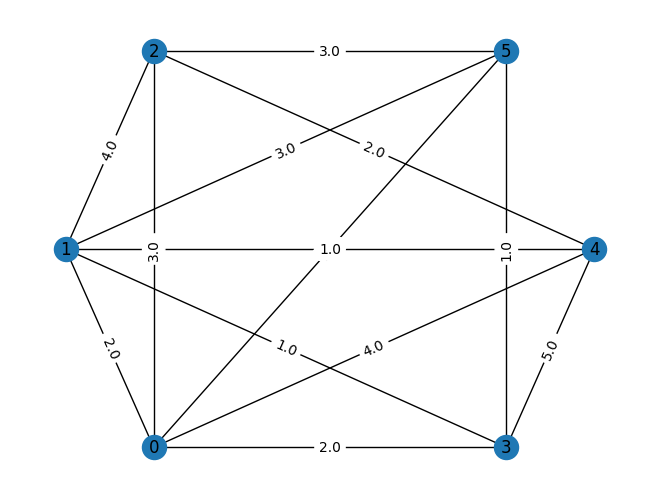

In [7]:
import networkx as nx
problemGraph=nx.Graph()
problemGraph.add_nodes_from(np.arange(0,6,1))
edges =[
    (0,1,2.0),
    (0,2,3.0),
    (0,3,2.0),
    (0,4,4.0),
    (0,5,1.0),
    (1,2,4.0),
    (1,3,1.0),
    (1,4,1.0),
    (1,5,3.0),
    (2,4,2.0),
    (2,5,3.0),
    (3,4,5.0),
    (3,5,1.0)
]
problemGraph.add_weighted_edges_from(edges)
graphsets['Graph1']=problemGraph

layout=[
    [0.3,0.3],
    [0.2,0.5],
    [0.3,0.7],
    [0.7,0.3],
    [0.8,0.5],
    [0.7,0.7]
]
labels=nx.get_edge_attributes(problemGraph,'weight')
nodeName={}
for i in range(6):
    nodeName[i]=f'{i}'
nx.draw(problemGraph,layout,with_labels=True)
nx.draw_networkx_edge_labels(problemGraph,pos=layout,edge_labels=labels)
# nx.draw_networkx_labels(problemGraph,layout,nodeName, font_size=13, font_color="whitesmoke")
num_nodes=problemGraph.number_of_nodes()

Define some help function here

In [8]:
def maxcut_cost_fn(graph: nx.Graph, bitstring: List[int]) -> float:
    """
    Computes the maxcut cost function value for a given graph and cut represented by some bitstring
    Args:
        graph: The graph to compute cut values for
        bitstring: A list of integer values '0' or '1' specifying a cut of the graph
    Returns:
        The value of the cut
    """
    weight_matrix = nx.adjacency_matrix(graph).toarray()
    size = weight_matrix.shape[0]
    value = 0.
    for i in range(size):
        for j in range(size):
            value = value + weight_matrix[i][j]*bitstring[i]*(1-bitstring[j])

    return value

def compute_expectation(counts, G):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring[::-1], G)
        avg += obj * count
        sum_count += count
    return avg/sum_count



Draw the objective value distribution solved by brute force(enumerate all the possiblities) way

/tmp/ipykernel_104471/1408241116.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph).toarray()


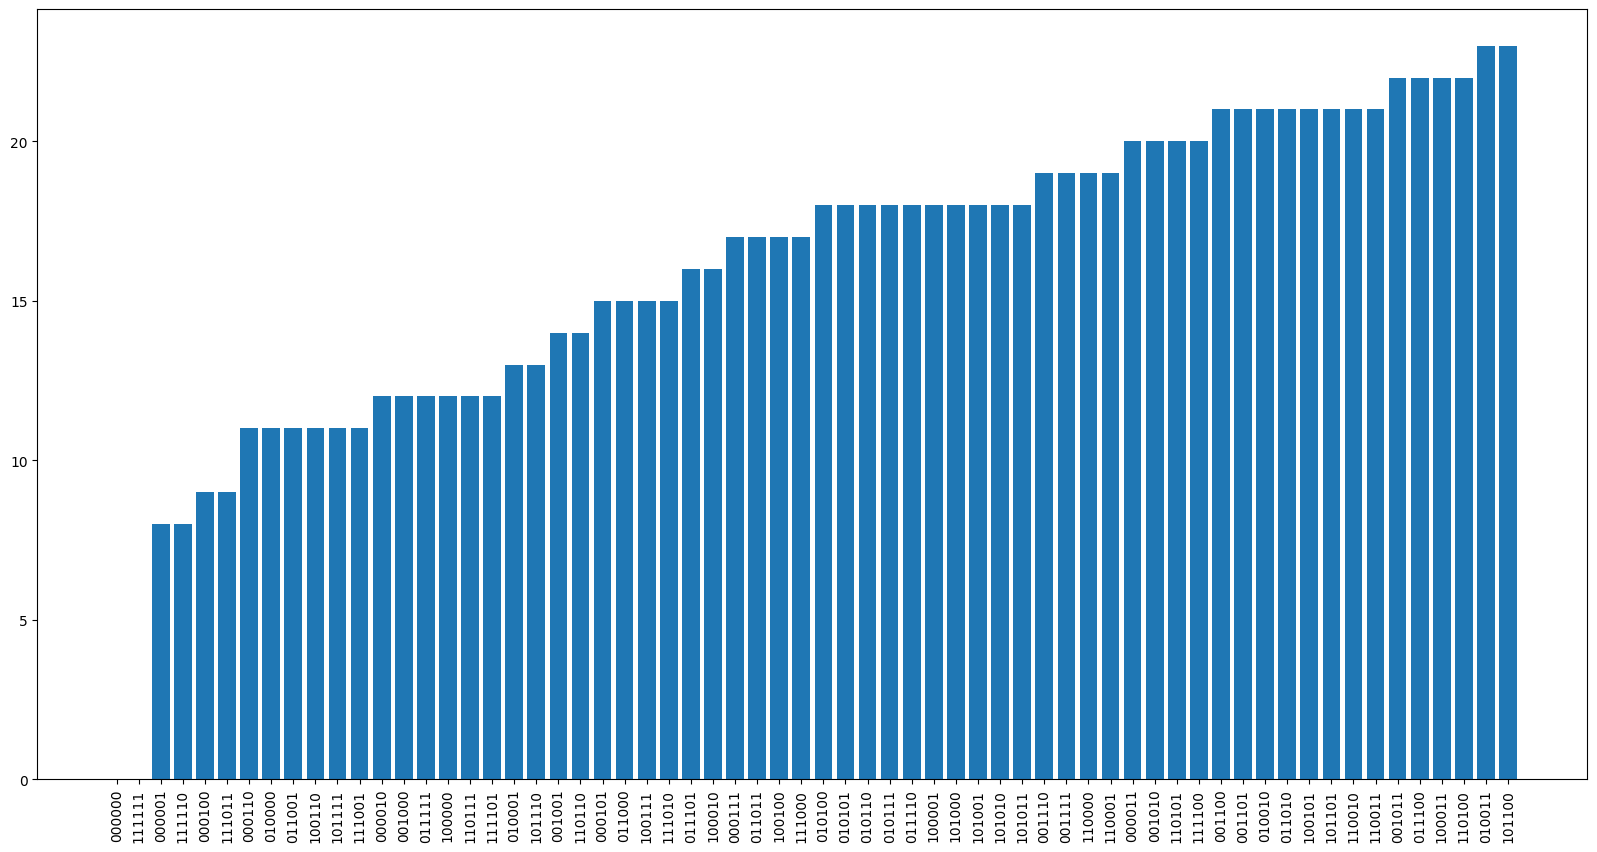

In [9]:
# plot_maxcut_histogram
num_vars = problemGraph.number_of_nodes()
bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
values = [maxcut_cost_fn(graph = problemGraph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]
#Sort both lists by largest cut value
values, bitstrings=zip(*sorted(zip(values, bitstrings)))
# plot
fig = plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
plt.bar(bitstrings, values)
plt.show()

<span style="color:red;font-size:25pt">The following text was copied from Qiskit textbook</span>

### Define MaxCut as Quadratic Problems
A quadratically constrained quadratic program is an optimization problem with a quadratic objective function and linear and quadratic constraints on the optimization variables. In other words, it can be written in the following form
$$
\begin{align}
\text{minimize} &&x^T Q x + c^T x &&\\
&& && \\
\text{subject to} &&Ax \leq b  &&\\
&& x^TQ_ix + a_i^Tx \leq r_i \\
&& l_j \leq x_j \leq u_j \\
\end{align}
$$
where $Q \in \mathbb{R}^{n \times n}$ is a symmetric real-valued $n \times n$-matrix and $c \in \mathbb{R}^n$ is a real-valued vector specifying the quadratic and linear parts of the objective function. The optimization variables $x_i, i \in \{1, \dots, n\}$ can be binary, integer- or real-valued, depending on the problem at hand.

### MaxCut as a Quadratic Program
We can formulate any MaxCut problem as a quadratic program. Consider again the cost function for a MaxCut problem with symmetric weight matrix $W$
$$
C(x) = \sum_{i,j=1}^n W_{ij} x_i (1-x_j).
$$
This is clearly a quadratic cost function and we can reformulate it in the standard form for quadratic programs as written above.
$$
\begin{align}
\sum_{i,j=1}^n W_{ij} x_i (1-x_j) &= \sum_{i,j=1}^n W_{ij} x_i - W_{ij}x_i x_j  \\
&= \sum_{i=1}^n \left( \sum_{j=1}^n W_{ij} \right) x_i - \sum_{i,j = 1}^n W_{ij}x_i x_j \\
&= c^T x + x^T Q x, \\
\end{align}
$$
for $Q$ and $c$ defined as follows
$$
Q_{ij} = -W_{ij} \qquad c_i = \sum_{j=1}^n W_{ij}.
$$
Thus, we obtain an optimization instance with binary variables, a quadratic objective function and without any variable constraints. A quadratic program of that form is also called a quadratic unconstrained binary optimization instance, or QUBO for short. In the next section, we will learn how to use QAOA to optimize problems of that type.

In [10]:
from qiskit_optimization import QuadraticProgram
quadratic_program = QuadraticProgram('sample_problem')

## The following code was modified from qiskit 2021 summer school lab2
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    #Get weight matrix of graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    #Build qubo matrix Q from weight matrix W
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i, j] -= weight_matrix[i, j]
    for i in range(size):
        for j in range(size):
            qubo_vector[i] += weight_matrix[i,j]

    QUBO = QuadraticProgram('MaxCut')
    for i in range(size):
        QUBO.binary_var(name=f'x_{i}')
    QUBO.maximize(quadratic=qubo_matrix,linear=qubo_vector)
    return QUBO

### Construct target circuit

In [11]:
## The following code was modified from qiskit 2021 summer school lab2
def construct_qaoa_circuit(qubo: QuadraticProgram, p: int = 1):
    size = len(qubo.variables)
    qubo_matrix = qubo.objective.quadratic.to_array(symmetric=True)
    qubo_linearity = qubo.objective.linear.to_array()

    #Prepare the quantum and classical registers
    qaoa_circuit = QuantumCircuit(size,size)
    #Apply the initial layer of Hadamard gates to all qubits
    qaoa_circuit.h(range(size))

    #Create the parameters to be used in the circuit
    gammas = ParameterVector('gamma', p)
    betas = ParameterVector('beta', p)

    #Outer loop to create each layer
    for i in range(p):

        #Apply R_Z rotational gates from cost layer
        for j in range(size):
            quadratic_sum=0
            for k in range(size):
                quadratic_sum=quadratic_sum+qubo_matrix[j][k]
            theta=(qubo_linearity[j]+quadratic_sum)*gammas[i]
            qaoa_circuit.rz(theta,j)

        #Apply R_ZZ rotational gates for entangled qubit rotations from cost layer
        for j in range(size):
            for k in range(size):
                if j!=k:
                    theta= qubo_matrix[j][k]*gammas[i]/2
                    qaoa_circuit.rzz(theta,j,k)
                        
        # Apply single qubit X - rotations with angle 2*beta_i to all qubits
        for j in range(size):
            qaoa_circuit.rx(2*betas[i],j)
    return qaoa_circuit

In [12]:
quadratic_program = quadratic_program_from_graph(problemGraph)
print(quadratic_program.export_as_lp_string())

/tmp/ipykernel_104471/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 12 x_0 + 11 x_1 + 12 x_2 + 9 x_3 + 12 x_4 + 8 x_5 + [ - 8 x_0*x_1
      - 12 x_0*x_2 - 8 x_0*x_3 - 16 x_0*x_4 - 4 x_0*x_5 - 16 x_1*x_2 - 4 x_1*x_3
      - 4 x_1*x_4 - 12 x_1*x_5 - 8 x_2*x_4 - 12 x_2*x_5 - 20 x_3*x_4 - 4 x_3*x_5
      ]/2
Subject To

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1
 0 <= x_5 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4 x_5
End



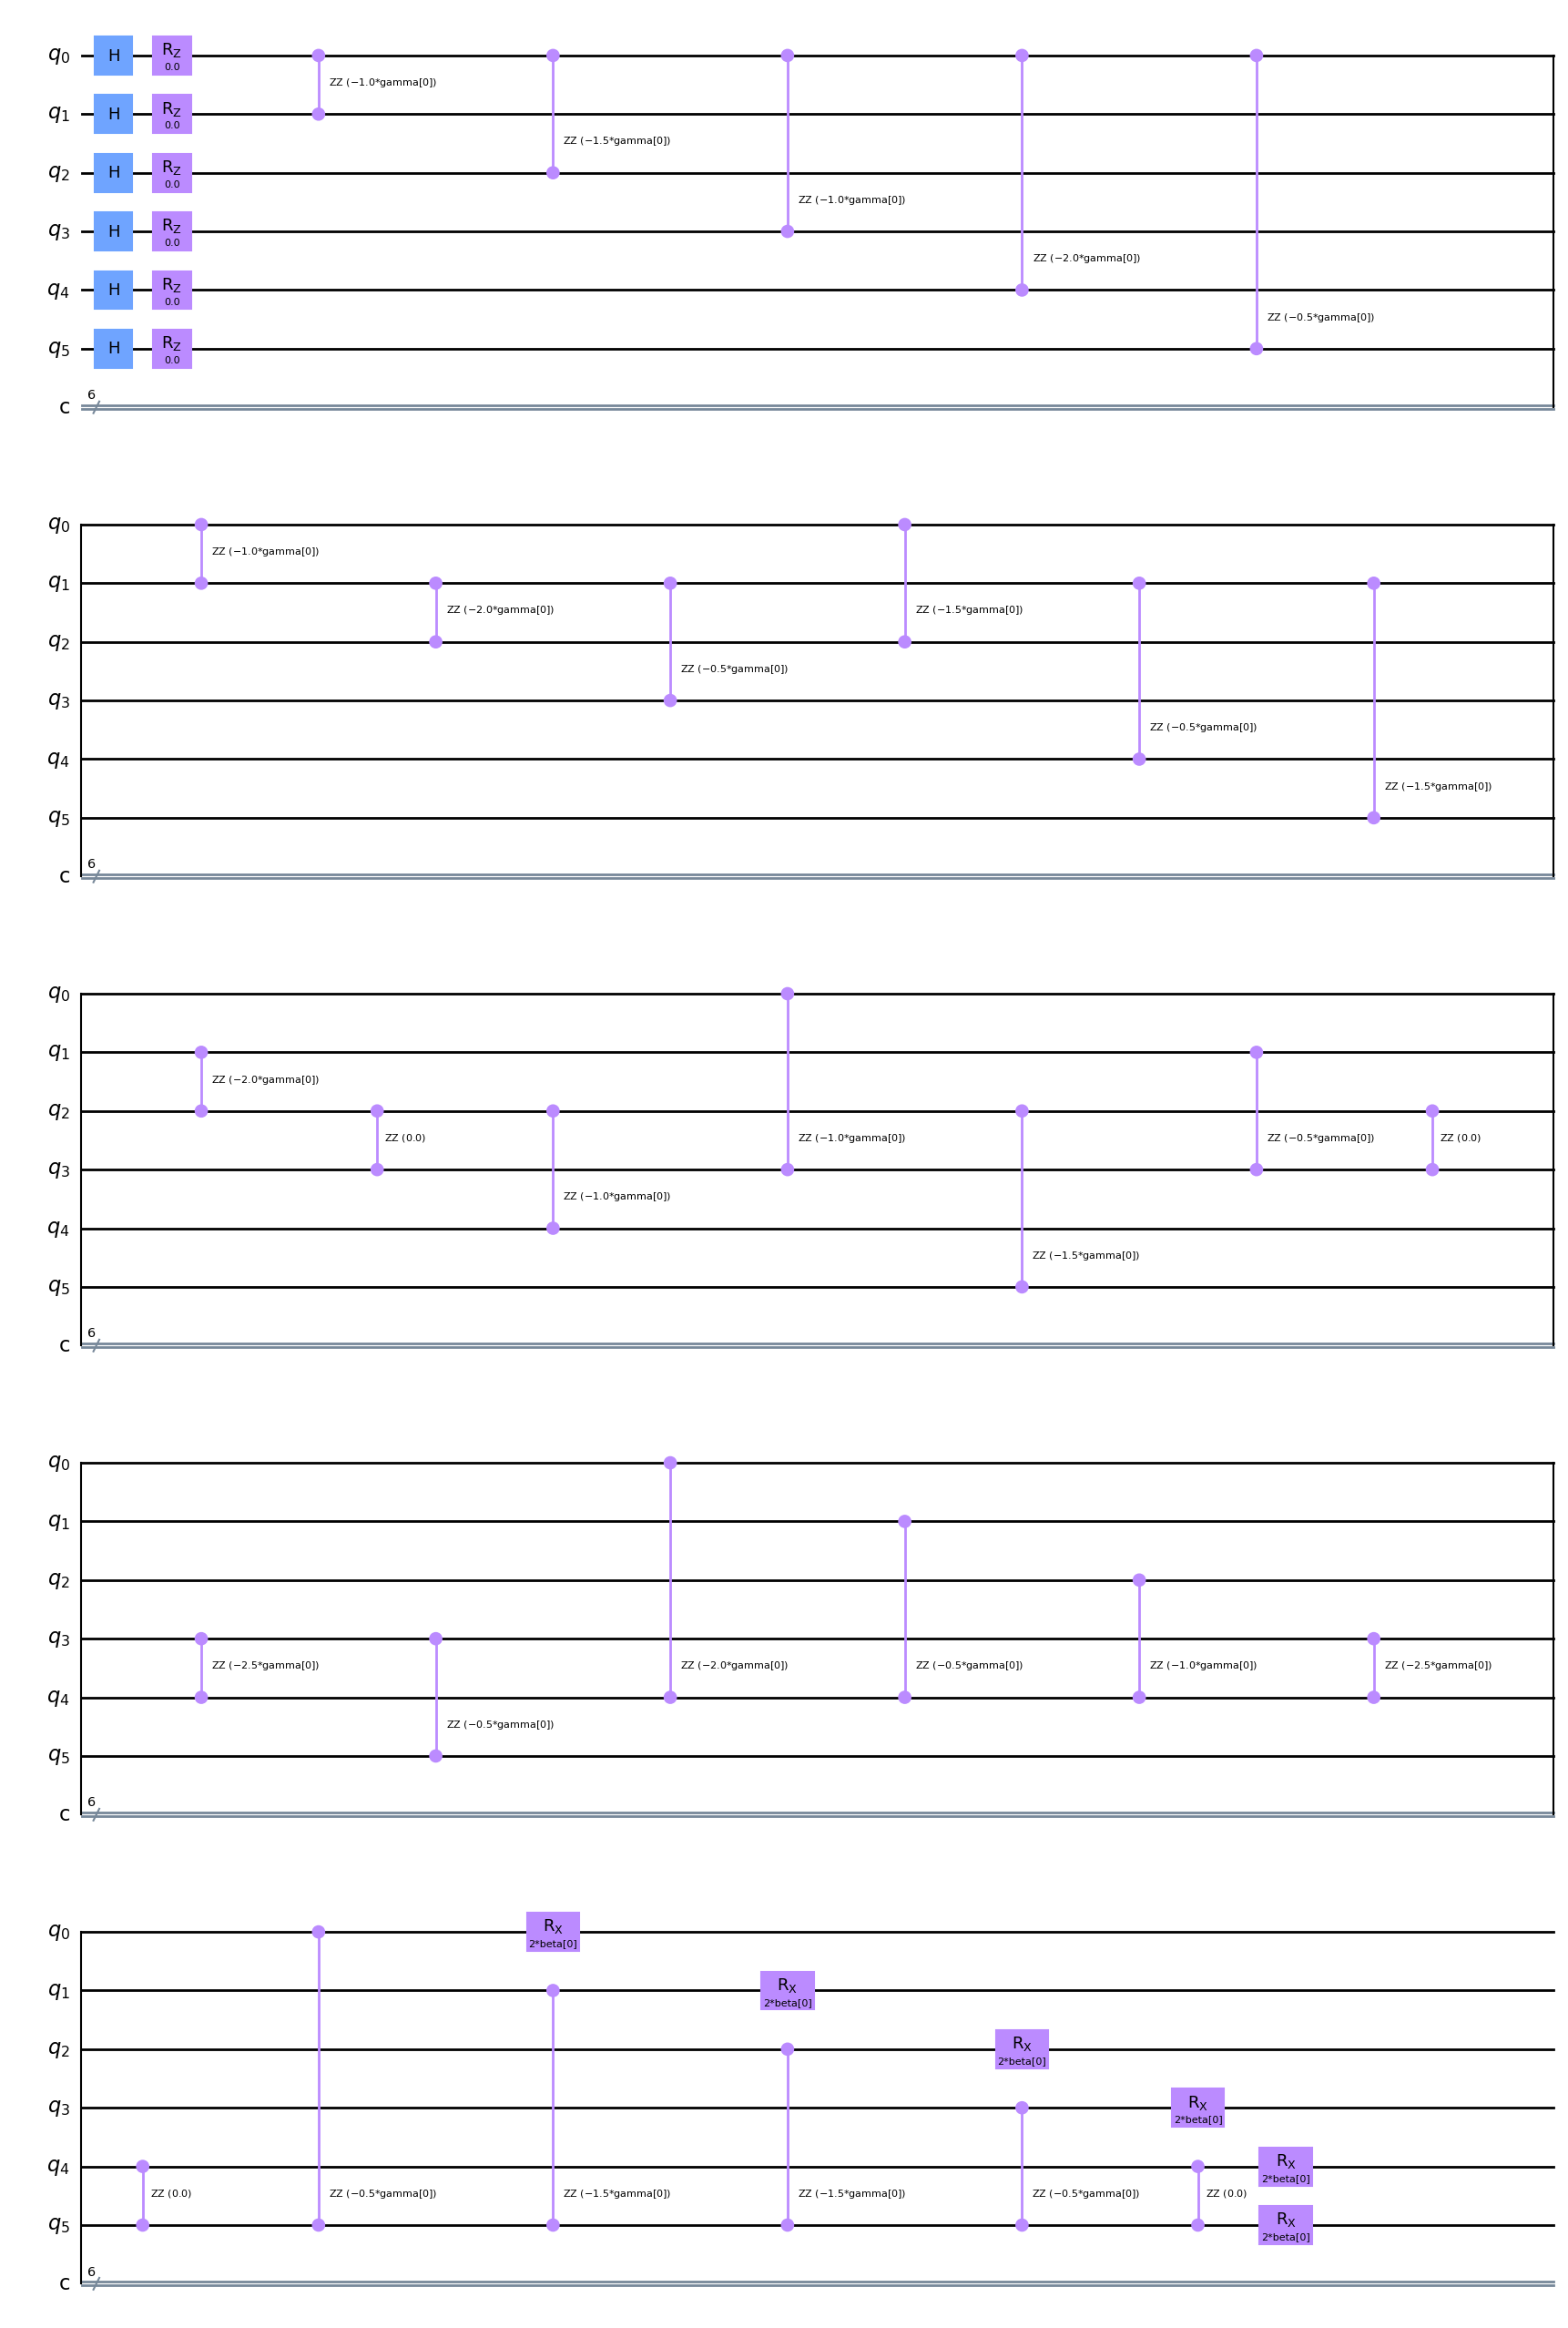

In [41]:
custom_circuit = construct_qaoa_circuit(qubo = quadratic_program)
custom_circuit.draw("mpl")

In [29]:
from qiskit.algorithms import QAOA
from qiskit_optimization.algorithms import MinimumEigenOptimizer
backend=Aer.get_backend('aer_simulator_statevector')
qaoa = QAOA(optimizer = COBYLA(), quantum_instance = backend, reps=1, initial_point = [0.1,0.1])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
quadratic_program = quadratic_program_from_graph(problemGraph)
result = eigen_optimizer.solve(quadratic_program)
print(result)

/tmp/ipykernel_104471/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)


fval=23.0, x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0, status=SUCCESS


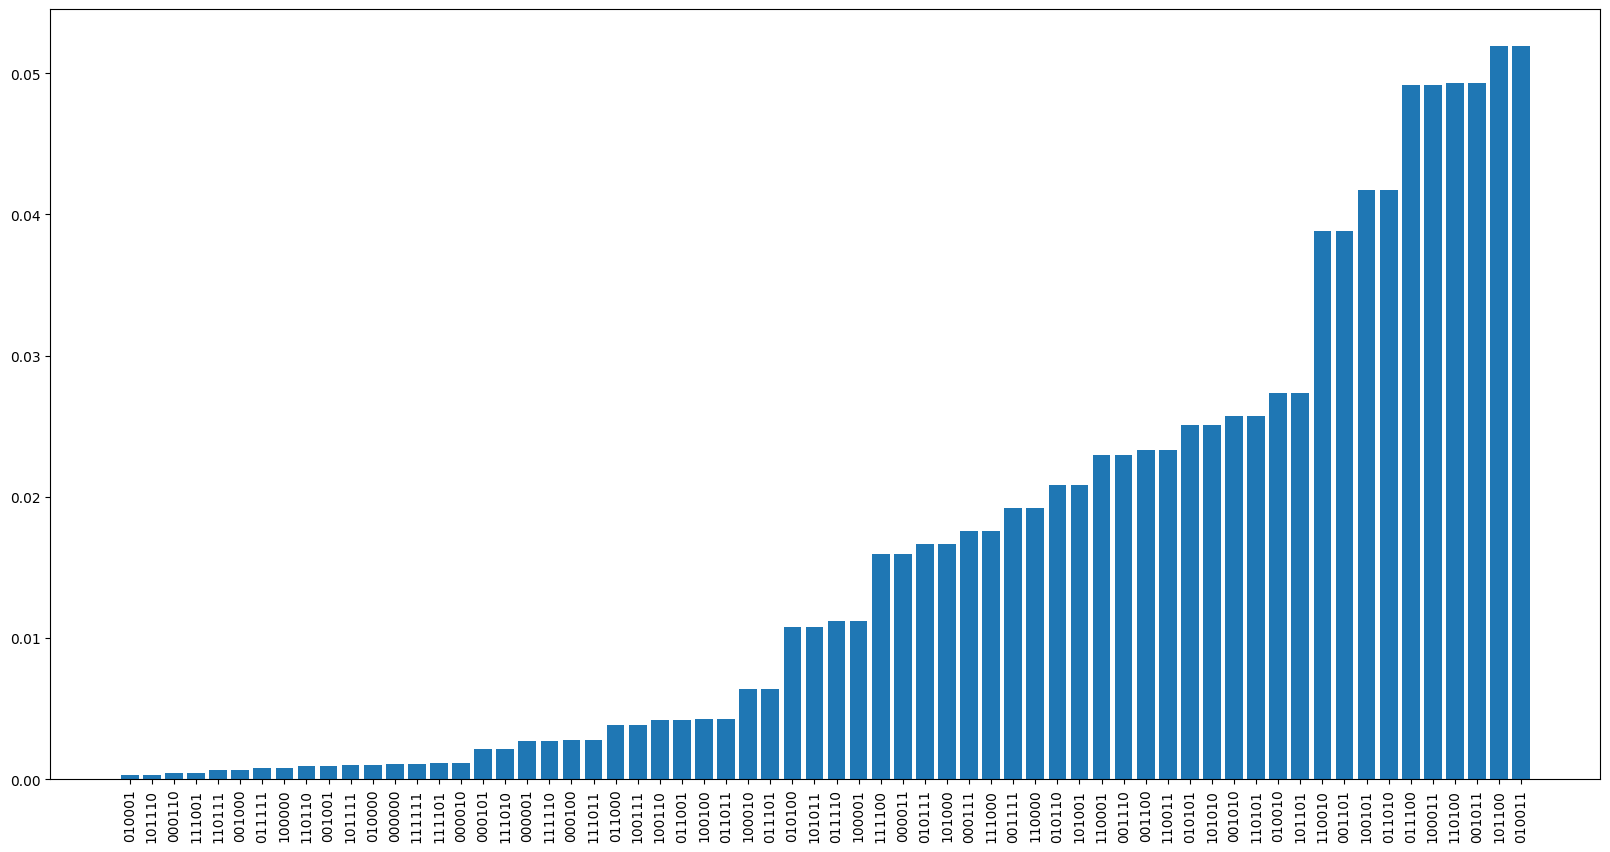

In [10]:
samples = sorted(result.samples, key = lambda x: x.probability)
probabilities = [sample.probability for sample in samples]
values = [sample.fval for sample in samples]
bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
#Plot bar diagram
fig = plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
plt.bar(bitstrings, probabilities)
plt.show()

### Grid search: Finding optimization surface and optimal solution

In [11]:
step_size=0.01
backend2 = Aer.get_backend('statevector_simulator')
# backend2 = Aer.get_backend('aer_simulator')
a_gamma=np.arange(0,4*np.pi,step_size)
a_beta=np.arange(0,np.pi,step_size)
a_energy=np.zeros((len(a_gamma),len(a_beta)))
para_circuit=construct_qaoa_circuit(qubo=quadratic_program)
parameters=para_circuit.parameters
bitstrings = ['{:b}'.format(i).rjust(num_vars, '0')[::-1] for i in range(2**num_vars)]
values = [maxcut_cost_fn(graph = problemGraph, bitstring = [int(x) for x in bitstring]) for bitstring in bitstrings]

for i in range(len(a_gamma)):
    for j in range(len(a_beta)):
        param_dict = {parameters[0]: a_beta[j] ,parameters[1]: a_gamma[i]}
        bound_circuit = para_circuit.assign_parameters(parameters = param_dict)
        job = backend2.run(bound_circuit)
        result=job.result()
        probabilities=result.get_statevector().probabilities()
        energy=0
        for k in range(len(probabilities)):
            energy+=probabilities[k]*values[k]
        energy=energy
        a_energy[i][j]=energy
np.save('energy.npy', a_energy)
# counts = {bitstrings[i]: probabilities[i] for i in range(len(bitstrings))}
# from qiskit.visualization import plot_histogram
# print(counts)
# plot_histogram(counts)
# fig = plt.figure(figsize=(20,10))
# plt.xticks(rotation = 90)
# plt.bar(bitstrings, probabilities)
# plt.show()

/tmp/ipykernel_9353/1408241116.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph).toarray()


In [12]:
step_size=0.01
a_gamma=np.arange(0,4*np.pi,step_size)
a_beta=np.arange(0,np.pi,step_size)
a_beta,a_gamma = np.meshgrid(a_beta,a_gamma)
a_energy=np.load('energy.npy') 

In [13]:
quadratic_program = quadratic_program_from_graph(graph=problemGraph)
trajectory={'beta_0':[], 'gamma_0':[], 'energy':[]}
offset = 1/4*quadratic_program.objective.quadratic.to_array(symmetric  = True).sum() + 1/2*quadratic_program.objective.linear.to_array().sum()
def callback(eval_count, params, mean, std_dev):
    trajectory['beta_0'].append(params[1])
    trajectory['gamma_0'].append(params[0])
    trajectory['energy'].append(-mean + offset)
optimizers = {
    'cobyla': COBYLA(),
    'slsqp': SLSQP(),
    'adam': ADAM()
}
qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=1, initial_point = [6.2,1.8],callback = callback)
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
result = eigen_optimizer.solve(quadratic_program)

/tmp/ipykernel_9353/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)


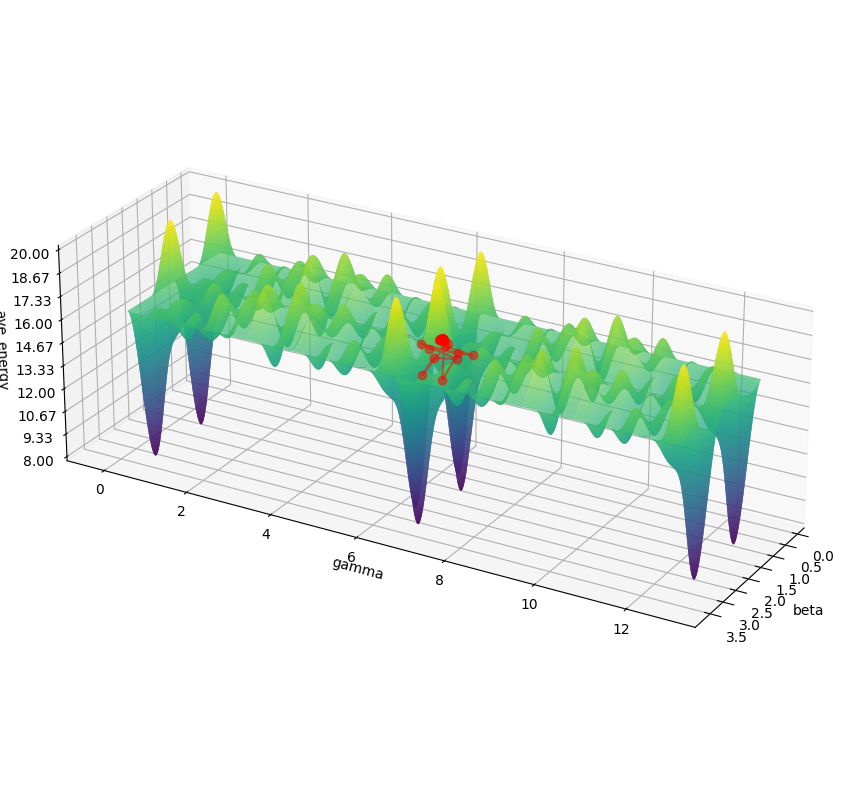

In [14]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig = plt.figure(figsize=(10,20))
ax = plt.axes(projection='3d')

surf =ax.plot_surface(a_beta, a_gamma, a_energy, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.plot(trajectory['beta_0'], trajectory['gamma_0'], [x for x in trajectory['energy']], 'ro-',  alpha=0.5,zorder=2.5)
ax.view_init(25, 30,0)

ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_zlabel('ave_energy');
ax.set_box_aspect((4, 12, 4))

ax.set_zlim(8,20)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.02f}')
# fig.colorbar(surf, shrink=0.5)
plt.show()

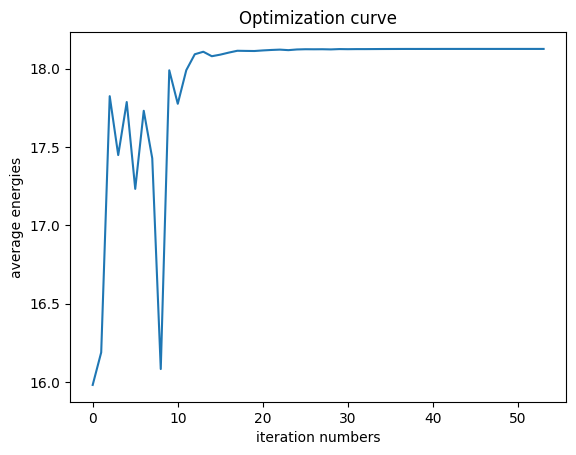

In [15]:
# np.ptp(a_beta)
plt.plot(np.arange(len(trajectory['energy'])),trajectory['energy'])
plt.title("Optimization curve")
plt.xlabel("iteration numbers")
plt.ylabel("average energies")
plt.show()

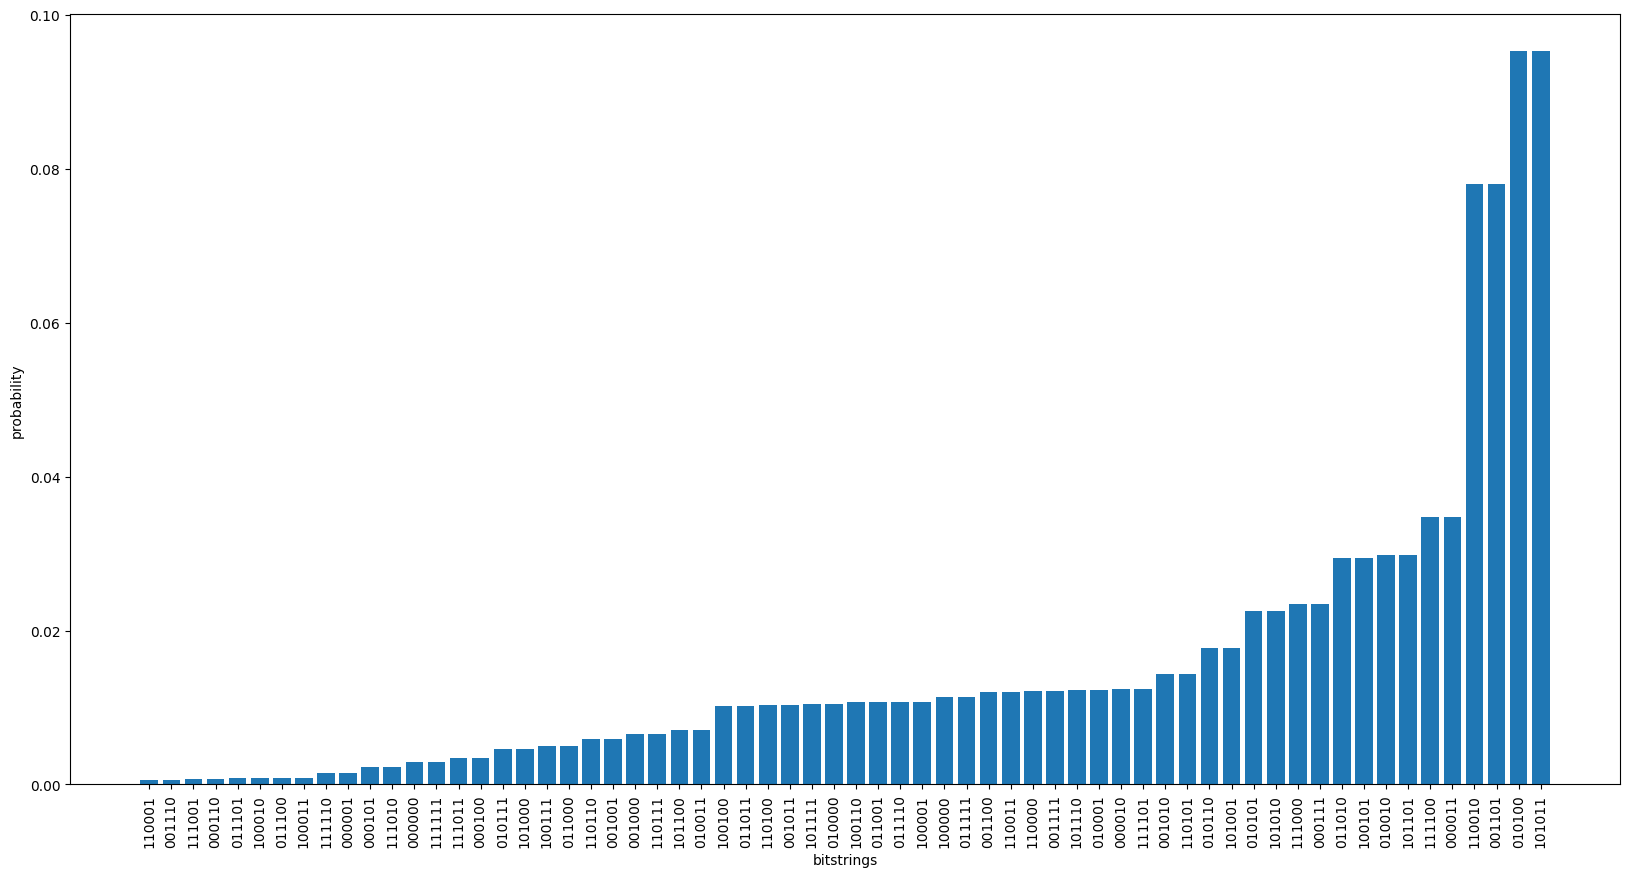

In [16]:
samples = sorted(result.samples, key = lambda x: x.probability)
probabilities = [sample.probability for sample in samples]
values = [sample.fval for sample in samples]
bitstrings = [''.join([str(int(i)) for i in sample.x]) for sample in samples]
#Plot bar diagram
fig = plt.figure(figsize=(20,10))
plt.xticks(rotation = 90)
plt.bar(bitstrings, probabilities)
plt.xlabel("bitstrings")
plt.ylabel("probability")
plt.show()

## Explore the factor of P
With higher values of $p$, QAOA is theoretically able to reach a quantum state with a better energy value with respect to the cost Hamiltonian since increasing the number of layers strictly increases the space of quantum states, one is able to reach. That is, if 
$$
M_p = \max_{\beta, \gamma \in \mathbb{R}^p} \langle \psi_p(\beta, \gamma) \vert H_C  \vert \psi_p(\beta, \gamma) \rangle
$$
denotes the maximal energy value reachable with a QAOA variational form of depth $p$, it holds that
$$
M_{p+1} \geq M_p.
$$
In fact, using the adiabatic theorem, one can prove, that in the infinite limit, we are able to reach the maximal cost function value $C_{max}$
$$
\lim\limits_{p \to \inf} M_p = C_{max}.
$$
While the connection to adiabatic quantum computing serves as a justification of why we might expect QAOA to yield good optimization results, it only holds in the infinite limit, which in turn corresponds to an infinitely long quantum algorithm.
One also needs to be mindful of the fact that the number of parameters increases with the number of layers, and finding the global optimum becomes increasingly harder when introducing more parameters.<br>
The following plots show the evolution of the optimal QAOA state found for increasing values of $p$ and give some idea of how the circuit depth affects QAOA performance.

In [17]:
quadratic_program = quadratic_program_from_graph(problemGraph)
#Create callback to record total number of evaluations
max_evals = 0
def callback(eval_count, params, mean, std_dev):
    global max_evals
    max_evals = eval_count

#Create empty lists to track values
energies = []
runtimes = []
num_evals=[]
    
#Run QAOA for different values of p
for p in range(1,10):
    print(f'Evaluating for p = {p}...')
    qaoa = QAOA(optimizer = optimizers['cobyla'], quantum_instance = backend, reps=p, callback=callback)
    eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver = qaoa)
    start = time()
    result = eigen_optimizer.solve(quadratic_program)
    runtimes.append(time()-start)
    num_evals.append(max_evals)
    #Calculate energy of final state from samples
    avg_value = 0.
    for sample in result.samples:
        avg_value += sample.probability*sample.fval
    energies.append(avg_value)
    
# #Create and display plots
# energy_plot = go.Scatter(x = list(range(1,10)), y =energies, marker=dict(color=energies, colorscale = 'plasma'))
# runtime_plot = go.Scatter(x = list(range(1,10)), y =runtimes, marker=dict(color=runtimes, colorscale = 'plasma'))
# num_evals_plot = go.Scatter(x = list(range(1,10)), y =num_evals, marker=dict(color=num_evals, colorscale = 'plasma'))
# fig = make_subplots(rows = 1, cols = 3, subplot_titles = ['Energy value', 'Runtime', 'Number of evaluations'])
# fig.update_layout(width=1800,height=600, showlegend=False)
# fig.add_trace(energy_plot, row=1, col=1)
# fig.add_trace(runtime_plot, row=1, col=2)
# fig.add_trace(num_evals_plot, row=1, col=3)
# clear_output()
# fig.show()

/tmp/ipykernel_9353/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)


Evaluating for p = 1...
Evaluating for p = 2...
Evaluating for p = 3...
Evaluating for p = 4...
Evaluating for p = 5...
Evaluating for p = 6...
Evaluating for p = 7...
Evaluating for p = 8...
Evaluating for p = 9...


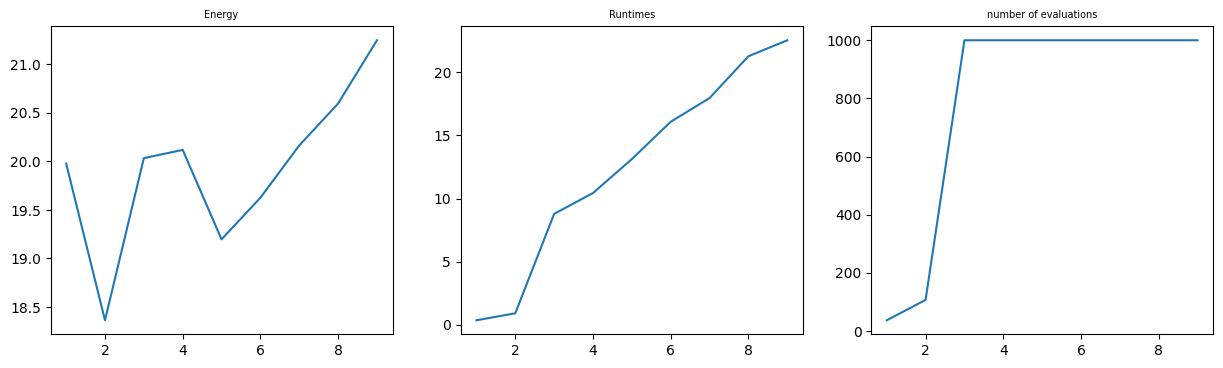

In [18]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,4)
axs[0].plot(list(range(1,10)), energies)
axs[0].axis('auto')
axs[0].set_title('Energy', fontsize=7)

axs[1].plot(list(range(1,10)), runtimes)
axs[1].set_title('Runtimes', fontsize=7)

axs[2].plot(list(range(1,10)), num_evals)
axs[2].set_title('number of evaluations', fontsize=7)

plt.show()

### CVaR
One recently proposed adaptation to QAOA is the idea of calculating the Conditional Value at Risk (or CVaR). Here, instead of calculating the mean of all cut values $c_i$ obtained from the measurement outcomes of the circuit to compute the cost function $f$, the algorithm only takes into account a fraction $\alpha$ of the highest measured cut values.
$$
f(\theta) = \frac{1}{n}\sum_{i=1}^n c_i \to f(\theta) = \frac{1}{\lceil \alpha n \rceil}\sum_{i=1}^{\lceil \alpha n \rceil} c_i,
$$
where the $c_i$ are ordered decreasing in size.
Since we are only interested in obtaining a single good solution for the original optimization problem, looking only at a fraction of the best cuts can help to speed up the optimization process. Let us explore how adding CVaR can change the energy landscape of a QAOA instance. The following code creates and plots a QAOA energy landscape of a given MaxCut instance using your code from the previous exercises and returns the optimal parameters obtained during a grid search. Calculating the energy landscape might take a while.


In [19]:
# the following code was modified from qiskit 2021 summer school
def plot_qaoa_energy_landscape(graph: nx.Graph, cvar: float = None):
    num_shots = 1000
    seed = 42
    simulator = Aer.get_backend('qasm_simulator')
    simulator.set_options(seed_simulator = 42)

    #Generate circuit
    circuit = construct_qaoa_circuit(qubo = quadratic_program_from_graph(graph), p=1)
    circuit.measure(range(graph.number_of_nodes()),range(graph.number_of_nodes()))

    #Create dictionary with precomputed cut values for all bitstrings 
    cut_values = {}
    size = graph.number_of_nodes()
    for i in range(2**size):
        bitstr = '{:b}'.format(i).rjust(size, '0')[::-1]
        x = [int(bit) for bit in bitstr]
        cut_values[bitstr] = maxcut_cost_fn(graph, x)

    #Perform grid search over all parameters
    data_points = []
    max_energy = None
    for beta in np.linspace(0,np.pi, 50):
        for gamma in np.linspace(0, 4*np.pi, 50):
            bound_circuit = circuit.assign_parameters([beta, gamma])
            result = simulator.run(bound_circuit, shots = num_shots).result()
            statevector = result.get_counts(bound_circuit)
            energy = 0
            measured_cuts = []
            for bitstring, count in statevector.items():
                measured_cuts =  measured_cuts + [cut_values[bitstring]]*count

            if cvar is None:
                #Calculate the mean of all cut values
                energy = sum(measured_cuts)/num_shots
            else:
                measured_cuts.sort(reverse=True)
                select_shot=int(np.ceil(cvar*num_shots))
                energy = sum(measured_cuts[:select_shot])/select_shot

            #Update optimal parameters
            if max_energy is None or energy > max_energy:
                max_energy = energy
                optimum = {'beta': beta, 'gamma': gamma, 'energy': energy}

            #Update data
            data_points.append({'beta': beta, 'gamma': gamma, 'energy': energy})


    #Create and display surface plot from data_points
    df = pd.DataFrame(data_points)
    df = df.pivot(index='beta', columns='gamma', values='energy')
    matrix = df.to_numpy()
    beta_values = df.index.tolist()
    gamma_values = df.columns.tolist()
    
    beta_values,gamma_values = np.meshgrid(beta_values,gamma_values)
    fig = plt.figure(figsize=(10,20))
    ax = plt.axes(projection='3d')    
    ax.plot_surface(beta_values, gamma_values, matrix, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none',linewidth=0.0, antialiased=True,rasterized=False)
    #     ax.plot(trajectory['beta_0'], trajectory['gamma_0'], [x for x in trajectory['energy']], 'ro-',  alpha=0.5,zorder=2.5)
    ax.view_init(25, 45,0)

    ax.set_xlabel('beta')
    ax.set_ylabel('gamma')
    ax.set_zlabel('ave_energy');
    ax.set_box_aspect((3, 12, 3))

    #     ax.set_zlim(8,20)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter('{x:.02f}')
    fig.colorbar(surf, shrink=0.5, aspect=2)
    plt.show()
    
    #Return optimum
    return optimum
#     return optimum,matrix,beta_values,gamma_values


/tmp/ipykernel_9353/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)
/tmp/ipykernel_9353/1408241116.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph).toarray()


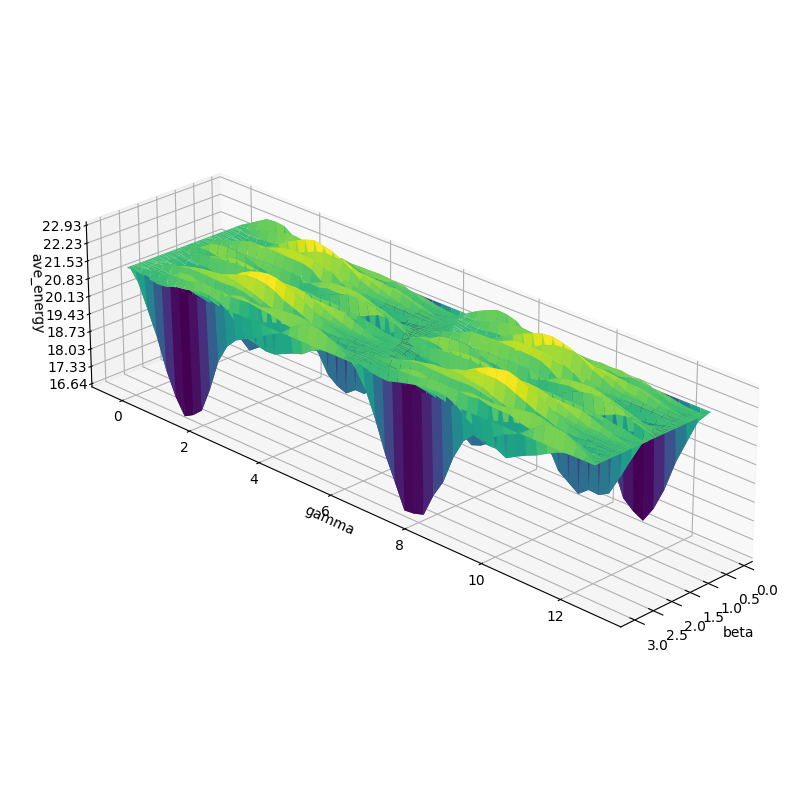

Optimal parameters:
{'beta': 0.7052554936630148, 'gamma': 2.821021974652059, 'energy': 22.925}


In [20]:
optimal_parameters= plot_qaoa_energy_landscape(graph = problemGraph,cvar=0.2)
print('Optimal parameters:')
print(optimal_parameters)

/tmp/ipykernel_9353/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)
/tmp/ipykernel_9353/1408241116.py:10: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph).toarray()


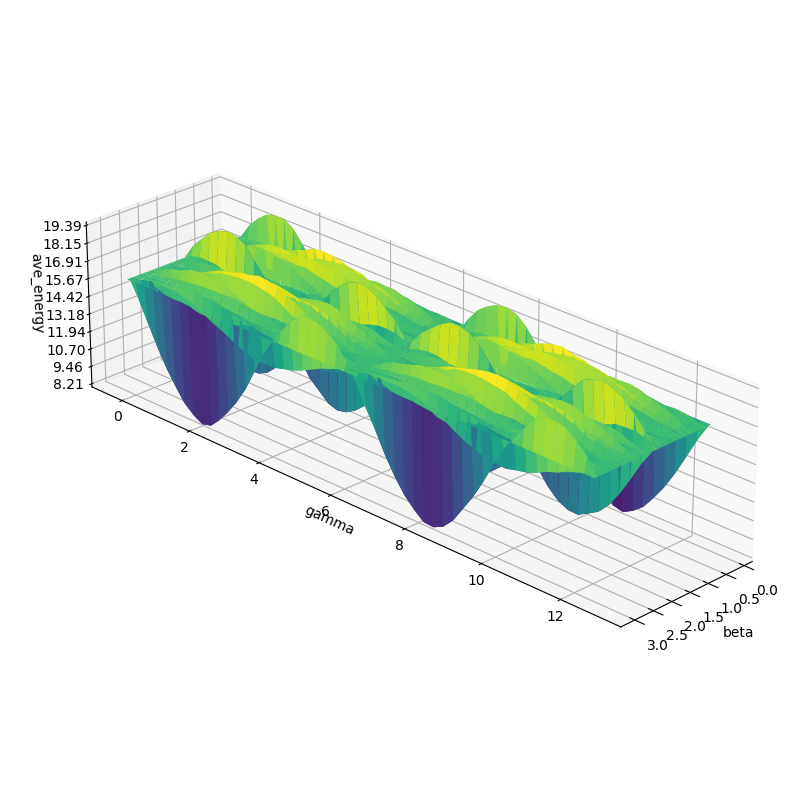

Optimal parameters:
{'beta': 0.32057067893773394, 'gamma': 6.411413578754679, 'energy': 19.392}


In [21]:
optimal_parameters= plot_qaoa_energy_landscape(graph = problemGraph)
print('Optimal parameters:')
print(optimal_parameters)

### Warm-starting QAOA

In [22]:
from qiskit_optimization.problems.variable import VarType
from qiskit_optimization.algorithms import GoemansWilliamsonOptimizer
from qiskit_optimization.converters.quadratic_program_to_qubo import QuadraticProgramToQubo

def relax_problem(problem) -> QuadraticProgram:
    """Change all variables to continuous."""
    relaxed_problem = copy.deepcopy(problem)
    for variable in relaxed_problem.variables:
        variable.vartype = VarType.CONTINUOUS
    return relaxed_problem


quadratic_program = quadratic_program_from_graph(problemGraph)
print(quadratic_program.prettyprint())

Problem name: MaxCut

Maximize
  -4*x_0*x_1 - 6*x_0*x_2 - 4*x_0*x_3 - 8*x_0*x_4 - 2*x_0*x_5 - 8*x_1*x_2
  - 2*x_1*x_3 - 2*x_1*x_4 - 6*x_1*x_5 - 4*x_2*x_4 - 6*x_2*x_5 - 10*x_3*x_4
  - 2*x_3*x_5 + 12*x_0 + 11*x_1 + 12*x_2 + 9*x_3 + 12*x_4 + 8*x_5

Subject to
  No constraints

  Binary variables (6)
    x_0 x_1 x_2 x_3 x_4 x_5



/tmp/ipykernel_9353/2231874408.py:7: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight_matrix = nx.adjacency_matrix(graph)


In [23]:
# qp = relax_problem(QuadraticProgramToQubo().convert(quadratic_program))
# print(qp.prettyprint())
sol = GoemansWilliamsonOptimizer(10).solve(quadratic_program)
print(sol.prettyprint())

objective function value: 23.0
variable values: x_0=0, x_1=1, x_2=0, x_3=0, x_4=1, x_5=1
status: SUCCESS


### Relex maxCut problem with GoemanWilliamson Algorithm

In [24]:
import cvxpy as cp
from scipy.linalg import sqrtm,norm

X = cp.Variable((num_nodes,num_nodes),symmetric=True)
constraints=[X>>0]
constraints+=[
    X[i,i] == 1 for i in range(num_nodes)
]

edges=[e for e in problemGraph.edges]
weight=nx.adjacency_matrix(problemGraph)
objective=sum(0.5*weight[i,j]*(1-X[i,j]) for (i,j) in edges)
prob=cp.Problem(cp.Maximize(objective),constraints)
prob.solve()
x=sqrtm(X.value)
u=np.random.randn(num_nodes)
u=u/norm(u)
np.sign(x@u)

/tmp/ipykernel_9353/298619427.py:11: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  weight=nx.adjacency_matrix(problemGraph)


array([-1.+0.j,  1.+0.j, -1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])

In [25]:
c_stars=np.real(x@u)
c_stars= [(val+1)/2 for val in c_stars]
eps=0.25
for i in range(len(c_stars)):
    if c_stars[i]<eps:
        c_stars[i]=eps
    if c_stars[i]>1-eps:
        c_stars[i]=1-eps
c_stars

[0.35995899857405755, 0.7219228350122674, 0.25, 0.25, 0.75, 0.6800165304904935]

In [26]:
from qiskit.utils.algorithm_globals import algorithm_globals
from qiskit.utils import QuantumInstance
from qiskit import BasicAer

algorithm_globals.random_seed = 12345

quantum_instance = QuantumInstance(
    BasicAer.get_backend("statevector_simulator"),
    seed_simulator=algorithm_globals.random_seed,
    seed_transpiler=algorithm_globals.random_seed,
)
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 1.0])

In [27]:
qaoa = MinimumEigenOptimizer(qaoa_mes)
qaoa_result = qaoa.solve(quadratic_program)
print(qaoa_result.prettyprint())

objective function value: 23.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


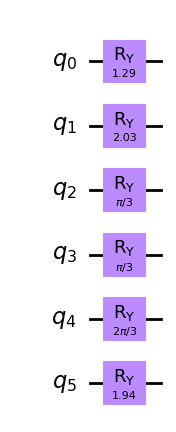

In [28]:
thetas = [2 * np.arcsin(np.sqrt(c_star)) for c_star in c_stars]

init_qc = QuantumCircuit(num_nodes)
for idx, theta in enumerate(thetas):
    init_qc.ry(theta, idx)

init_qc.draw(output="mpl")

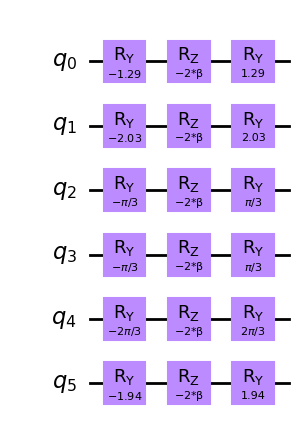

In [29]:
beta = Parameter("β")

ws_mixer = QuantumCircuit(num_nodes)
for idx, theta in enumerate(thetas):
    ws_mixer.ry(-theta, idx)
    ws_mixer.rz(-2 * beta, idx)
    ws_mixer.ry(theta, idx)

ws_mixer.draw(output="mpl")

In [30]:
ws_qaoa_mes = QAOA(
    quantum_instance=quantum_instance,
    initial_state=init_qc,
    mixer=ws_mixer,
    initial_point=[0.0, 1.0],
)

In [31]:
ws_qaoa = MinimumEigenOptimizer(ws_qaoa_mes)

In [32]:
ws_qaoa_result = ws_qaoa.solve(quadratic_program)
print(ws_qaoa_result.prettyprint())

objective function value: 23.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


### Analyze warm start QAOA

In [33]:
def format_qaoa_samples(samples, max_len: int = 10):
    qaoa_res = []
    for s in samples:
        if sum(s.x) == 3:
            qaoa_res.append(("".join([str(int(_)) for _ in s.x]), s.fval, s.probability))

    res = sorted(qaoa_res, key=lambda x: -x[1])[0:max_len]

    return [(_[0] + f": value: {_[1]:.3f}, probability: {1e2*_[2]:.1f}%") for _ in res]

format_qaoa_samples(qaoa_result.samples)

['101100: value: 23.000, probability: 0.2%',
 '010011: value: 23.000, probability: 0.2%',
 '110100: value: 22.000, probability: 1.2%',
 '011100: value: 22.000, probability: 3.6%',
 '100011: value: 22.000, probability: 3.6%',
 '001011: value: 22.000, probability: 1.2%',
 '110010: value: 21.000, probability: 0.5%',
 '011010: value: 21.000, probability: 5.8%',
 '100101: value: 21.000, probability: 5.8%',
 '001101: value: 21.000, probability: 0.5%']

In [34]:
format_qaoa_samples(ws_qaoa_result.samples)

['101100: value: 23.000, probability: 0.0%',
 '010011: value: 23.000, probability: 11.1%',
 '110100: value: 22.000, probability: 0.3%',
 '011100: value: 22.000, probability: 0.3%',
 '100011: value: 22.000, probability: 2.0%',
 '001011: value: 22.000, probability: 1.4%',
 '110010: value: 21.000, probability: 4.0%',
 '011010: value: 21.000, probability: 2.5%',
 '100101: value: 21.000, probability: 0.4%',
 '001101: value: 21.000, probability: 0.2%']

### Try built-in WARM-start QAOA

In [35]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer
qaoa_mes = QAOA(quantum_instance=quantum_instance, initial_point=[0.0, 1.0])
# ws_qaoa = WarmStartQAOAOptimizer(
#     pre_solver=CplexOptimizer(), relax_for_pre_solver=True, qaoa=qaoa_mes, epsilon=0.25
# )
ws_qaoa = WarmStartQAOAOptimizer(
    pre_solver=GoemansWilliamsonOptimizer(10), relax_for_pre_solver=False, qaoa=qaoa_mes, epsilon=0.25
)
ws_result = ws_qaoa.solve(quadratic_program)
# ws_result=GoemansWilliamsonOptimizer(10).solve(quadratic_program)
print(ws_result.prettyprint())

objective function value: 23.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=1.0, x_4=0.0, x_5=0.0
status: SUCCESS


### run on a real quantum computer - IBMQ

In [38]:
from qiskit import IBMQ, execute, transpile, Aer,assemble
from qiskit.tools.monitor import job_monitor
# IBMQ.save_account("TOKEN", overwrite=True) 
# IBMQ.save_account("0760bfe225b90d", overwrite=True) 
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")


ibmqfactory.load_account:WARNING:2022-12-12 00:25:18,442: Credentials are already in use. The existing account in the session will be replaced.


In [43]:
backend = provider.get_backend('ibm_nairobi')

custom_circuit2 = custom_circuit.assign_parameters([0.7053,2.82])
# prepare the circuit for the backend
mapped_circuit = transpile(custom_circuit2, backend=backend)
qobj = assemble(mapped_circuit, backend=backend, shots=1024)

# execute the circuit
job = backend.run(qobj)

/tmp/ipykernel_104471/2373371402.py:9: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


In [45]:
job.job_id()

'6396bc147bff6e79a5af81fb'

In [ ]:
job = provider.get_backend('ibmq_quito').retrieve_job('6396bc147bff6e79a5af81fb')
result = job.result()
counts = result.get_counts()
print(counts)

### Improve warm start: SDP strategy(Future Study)

In [46]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright